# Algorithmen aus dem Buch Kapitel 10 Machine Learning 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sklearn.datasets
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns
import urllib
from pathlib import Path
import tarfile
import hashlib
import scipy
import sys
sys.version_info
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()
import itertools
from collections import namedtuple
from dataclasses import dataclass

## Klassifikation 

Bei dieser Art von Problemen geht es darum Daten möglichst gut zu klassifizieren.

Beispielsweise bei Früchten zu unterscheiden, ob diese eine Apfel oder eine Birne ist.

In [15]:
def map_0_1_to_minus_1_1(labels):
    """
    Es werden die Labels von 0 und 1 auf -1 und 1 abgebildet.
    """
    return 2 * labels - 1

In [16]:
@dataclass
class Dataset:
    name: str
    features: np.array
    labels: np.array

In [17]:
def generate_blobs_dataset(number_of_samples=1000, scale=1, random_state=np.random, name='blobs'):
    labels = random_state.choice([0, 1], size=number_of_samples)
    cluster_centers = random_state.normal(scale=scale, size=(2, 2))
    features = cluster_centers[labels, :] + random_state.normal(size=(number_of_samples, 2))
    return Dataset(name, features, map_0_1_to_minus_1_1(labels))


In [ ]:
easy_blobs = generate_blobs_dataset(scale=4, random_state=np.random.RandomState(0), name='easy_blobs')

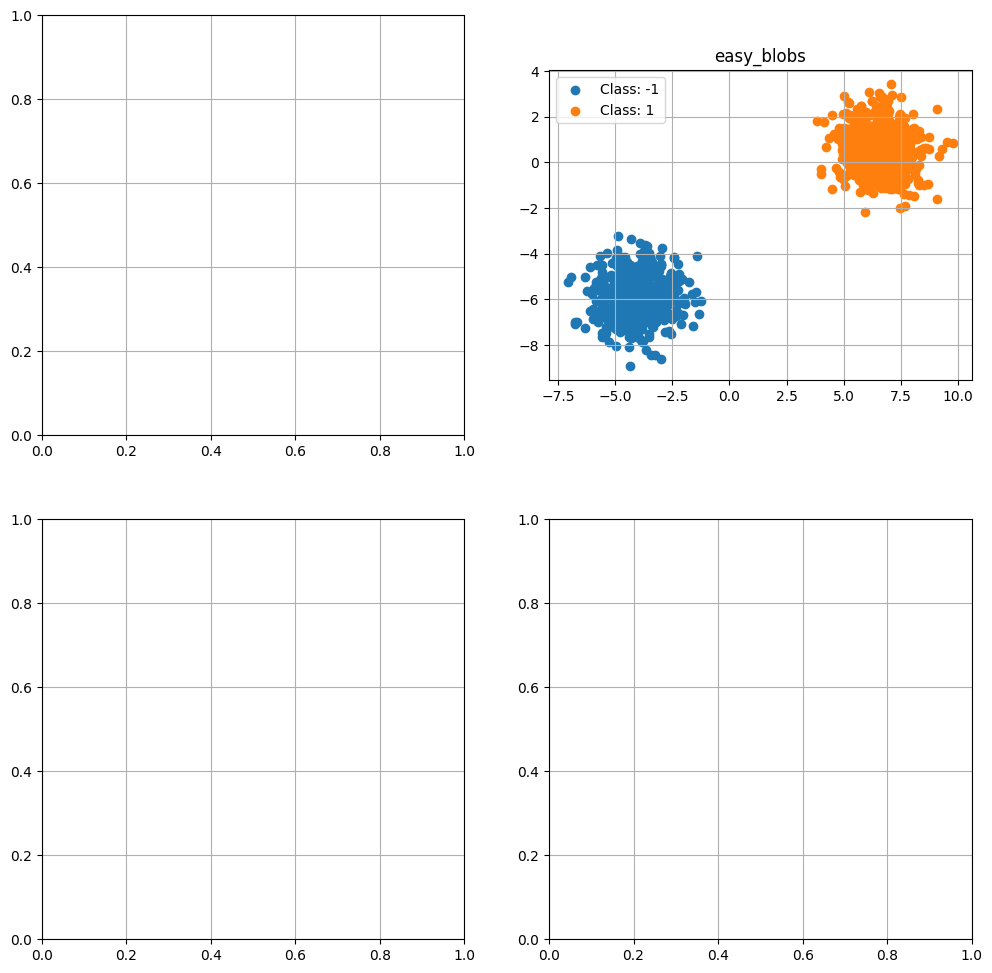

In [25]:
def plot_dataset(dataset, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    classes = np.unique(dataset.labels)
    classes = np.sort(classes)
    for c in classes:
        ax.scatter(
            dataset.features[dataset.labels == c, 0],
            dataset.features[dataset.labels == c, 1],
            label=f'Class: {c}',
        )
    ax.set_aspect('equal')
    if title is None:
        title = dataset.name
    ax.set_title(title)
    ax.legend()
figure, axes = plt.subplots(2, 2, figsize=(12, 12))
plot_dataset(easy_blobs, ax=axes[0, 1])

### Linear Regression

### K-NN

## Kapitel 3.2 Stochastic Gradient Decent

Erweiterung von Gradient Decent, welche im Machine Learning zum Einsatz kommt.


In [18]:
def get_learning_rate(epoch):
    # This is a fixed learning rate schedule.
    initial_learning_rate = 0.01  
    if epoch <= 5: 
        return initial_learning_rate  
    else:  
        return initial_learning_rate * 10 ** -(epoch - 5) 

def get_gradient_theta(X, y, theta):
    batch_size = X.shape[0]  
    return -(X.T @ y - X.T @ X @ theta) / batch_size  

def fit(
    X_train, y_train,
    X_test, y_test,
    epochs=10,
    batch_size=10,
    logging=True
):
    number_of_examples, number_of_parameters = X_train.shape
    
    # Set up batching parameters
    all_example_indices = list(range(number_of_examples))
    number_of_batches = -(-number_of_examples // batch_size)
    
    # Initialize variables
    theta = np.zeros(number_of_parameters)
    
    # Prepare logging
    if logging:
        train_error_history = []
        test_error_history = []
        theta_history = []
    else:
        train_error_history = None
        test_error_history = None
        theta_history = None
    
    for epoch in range(epochs):
        learning_rate = get_learning_rate(epoch)
        np.random.shuffle(all_example_indices)  # REPLACE ???  # shuffle all_example_indices
        
        for mini_batch in np.array_split(all_example_indices, number_of_batches):  # REPLACE ???  # for mini_batch in ???:
            gradient = get_gradient_theta(  # REPLACE ???
                X_train[mini_batch, :],  # REPLACE
                y_train[mini_batch],  # REPLACE
                theta  # REPLACE
            )  # REPLACE
            theta = theta - learning_rate * gradient  # REPLACE
            
            if logging:
                theta_history.append(theta)
                train_error_history.append(
                    root_mean_squared_error(X_train, y_train, theta)
                )
                test_error_history.append(
                    root_mean_squared_error(X_test, y_test, theta)
                )
    
    if logging:
        train_error_history = np.asarray(train_error_history)
        test_error_history = np.asarray(test_error_history)
        theta_history = np.asarray(theta_history)
    
    return theta, train_error_history, test_error_history, theta_history

theta, train_error_history, test_error_history, theta_history = fit(
    X, y,
    X_test, y_test,
    epochs=10,
    batch_size=10,
    logging=True
)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

ax = axes[0]
ax.plot(np.log(train_error_history), label='Train error')
ax.plot(np.log(test_error_history), color='red', label='Test error')
ax.set_xlabel('Iteration')
ax.set_ylabel('Root Mean Squared Error')
ax.legend()

ax = axes[1]
ax.plot(theta_history[:, 0], theta_history[:, 1])
ax.scatter(theta[0], theta[1], color='red', zorder=3, s=100)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')

plt.show()
print('Best test loss: {:10.0f}'.format(np.min(test_error_history)))

NameError: name 'X' is not defined

## K - Means Clustering 

Ein Algo. der im Kontext von unsupervised learning verwendet wird

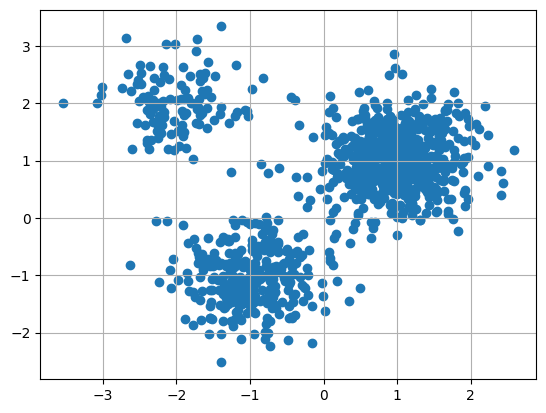

In [ ]:
N = 1000
p = np.array([0.3, 0.6, 0.1])
K = p.shape[0]
labels = np.random.choice(range(K), size=(N,), p=p)
means = np.array([[-1, -1], [1, 1], [-2, 2]])
D = means.shape[-1]
x = np.sqrt(1 / 4) * np.random.normal(size=(N, D))

for k in range(K):
    x[labels == k, :] += means[k, :]

plt.scatter(x[:, 0], x[:, 1])

Implementation des K-Means Clustering